In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pynbody
from sklearn.model_selection import train_test_split

import torch
import torch.utils.data as data
from torch import nn

#Target distribution to map z
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta

# Data

## Generate data function

In [2]:
def generate_mixture_of_gaussians(num_of_points):
    n = num_of_points // 2
    gaussian1 = np.random.normal(loc=-1, scale=0.25, size=(n, )) #first gaussian(-1, 0.25, number of point)
    gaussian2 = np.random.normal(loc=0.5, scale=0.5, size=(num_of_points-n, ))
    return np.concatenate([gaussian1, gaussian2])


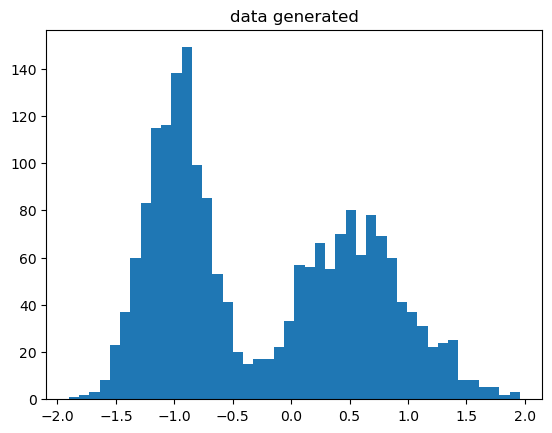

In [3]:
x = generate_mixture_of_gaussians(2000)
plt.hist(x, bins=int(np.sqrt(len(x))))
plt.title('data generated');

## Pytorch _loader

In [4]:
#this is a Dataset both sample and labels are stored
class NumpyDataset(data.Dataset):  
    def __init__(self, array):
        super().__init__()
        self.array = array
    
    def __len__(self):
        return len(self.array)
    
    def __getitem__(self, index):
        return self.array[index]
    
n_train, n_test = 20000, 10000
train_data = generate_mixture_of_gaussians(n_train)
test_data  = generate_mixture_of_gaussians(n_test)

#this is a DataLoader, it wraps an iterable around the DataSet
train_loader = data.DataLoader(NumpyDataset(train_data), batch_size=128, shuffle=True)
test_loader  = data.DataLoader(NumpyDataset(test_data),  batch_size=128, shuffle=True) 

# Model

We are gonna use CDFs of normal distributions as function f as follows : 

$z = f(x) = \Sigma_i w_i CDF(x; \mu_i, \sigma_i)$ 

with $\Sigma_i w_i = 1$

We want to find $\mu_i$ and $\sigma_i$, and also the weights $w_i$.

In [5]:
class Flow1d(nn.Module):
    def __init__(self, n_components):                                                   #we have defined the n_components as the number of CDF_i of the transformation function
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)          #the mean
        self.log_sigmas = nn.Parameter(torch.randn(n_components), requires_grad=True)    # the log(sigma)
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True) #the imput of the softmax function that return the weights (they some to one)
        
    def forward(self, x):
        x = x.view(-1, 1)                                       #this put the data in shape (len(data), 1)
        weights = self.weight_logits.softmax(dim=0).view(1, -1) # (1, n_components)
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = (distribution.cdf(x) * weights).sum(dim=1)          # (len(data), n_components) * (1, n_components) = (len(data), n_components)
        dz_by_dx = (distribution.log_prob(x).exp()*weights).sum(dim=1) #log_prob(x).exp() returns the density of the normal distribution at x, rather complicated
        
        return z, dz_by_dx

# Train and Evaluation function

In [6]:
def loss_function(target_distribution, z, dz_by_dx):                   #we could use as a target distribution for z the Uniform(0,1) or the Normal
    log_likelihood = target_distribution.log_prob(z) + dz_by_dx.log()
    return -log_likelihood.mean()

def train(model, train_loader, optimizer, target_distribution):
    model.train()              #this put the model in training mode, no inference
    for x in train_loader:
        z, dz_by_dx = model(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        optimizer.zero_grad()  #clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
        loss.backward()        #computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation
        optimizer.step()       #causes the optimizer to take a step based on the gradients of the parameters
        
def eval_loss(model, data_loader, target_distribution):
    model.eval()                 #this put the model in evaluation mode, no inference
    total_loss = 0
    for x in data_loader:
        z, dz_by_dx = model(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        total_loss+= loss * x.size(0)
    return (total_loss / len(data_loader.dataset)).item() #.item() return the value of the tensor as a scalar

def train_and_eval(epochs, lr, train_loader, test_loader, target_distribution, n_components=5):
    flow = Flow1d(n_components)
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in tqdm(range(epochs)):
        train(flow, train_loader, optimizer, target_distribution)
        train_losses.append(eval_loss(flow, train_loader, target_distribution))
        test_losses.append(eval_loss(flow, test_loader, target_distribution))
    return flow, train_losses, test_losses 

# Trainining and Results

## Visualize training and testing data

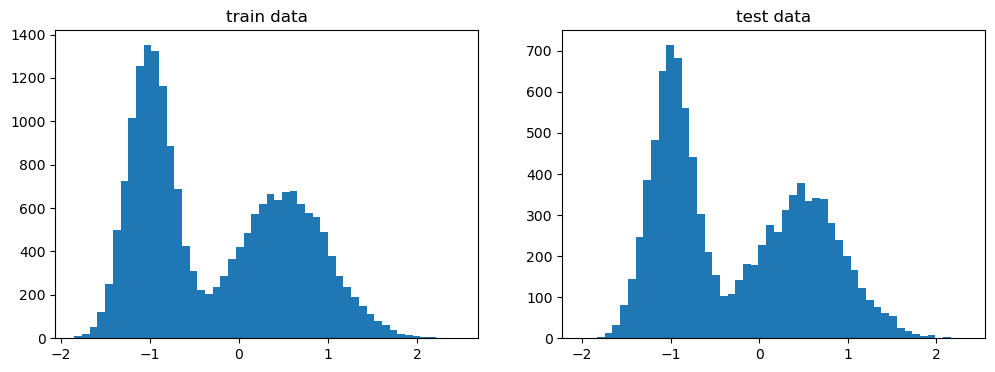

In [7]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[0].set_title("train data")
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[1].set_title("test data")

## Train the flow model 

In [8]:
target_distribution = Uniform(0.0, 1.0)
flow, train_losses, test_losses = train_and_eval(50, 5e-3, 
                                                 train_loader, test_loader,
                                                 target_distribution, n_components=5)

100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.30it/s]


## Losses view

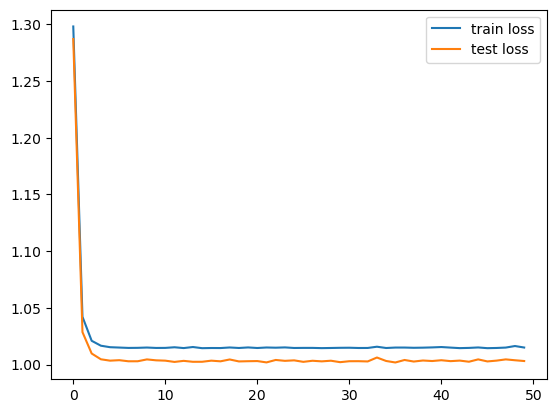

In [9]:
_ = plt.plot(train_losses, label='train loss')
_ = plt.plot(test_losses, label='test loss')
plt.legend();

## Learned distribution for X

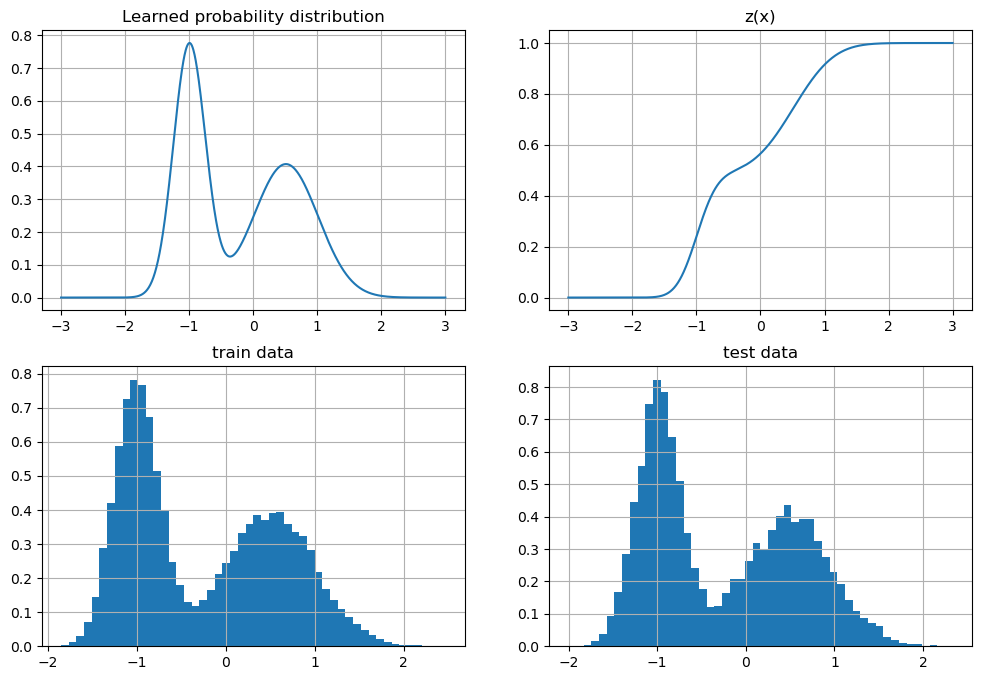

In [10]:
x = np.linspace(-3, 3, 1000)
with torch.no_grad():  #useful for inference, dosen't calculate the gradient
    z, dz_by_dx = flow(torch.FloatTensor(x)) #now flow is in inference mode
    px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().cpu().numpy()
    
_, axes = plt.subplots(2,2, figsize=(12, 8))
_ = axes[0, 0].grid(), axes[0, 1].grid(), axes[1, 0].grid(), axes[1, 1].grid()
_ = axes[0, 0].plot(x, px)
_ = axes[0, 0].set_title('Learned probability distribution')

_ = axes[0, 1].plot(x, z) #our target distribution as a combiantion of CDF 
_ = axes[0, 1].set_title('z(x)')

_ = axes[1, 0].hist(train_loader.dataset.array, bins=50, density=True)
_ = axes[1, 0].set_title("train data")
_ = axes[1, 1].hist(test_loader.dataset.array, bins=50, density=True)
_ = axes[1, 1].set_title("test data")

# Data from Simulation

In [11]:
s = pynbody.load('data/g8.26e11/snap_2000/output/8.26e11.02000')
h = s.halos()

feh_array = np.array(s.s['feh'])
feh_array = feh_array[feh_array > np.percentile(feh_array, 0.1)]

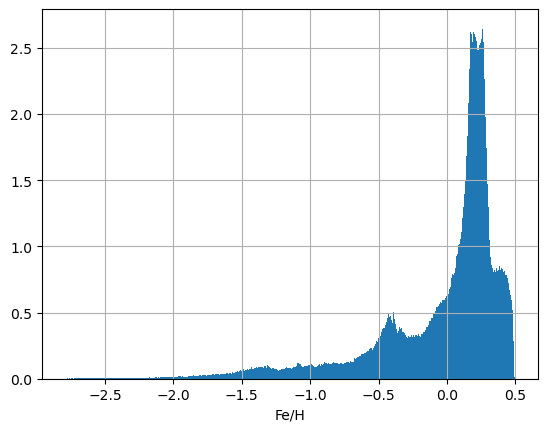

In [12]:
plt.hist(feh_array, bins='sqrt', density=True)
plt.grid()
plt.xlabel('Fe/H');

In [13]:
#let's put it into a dataloader
train_data, test_data = train_test_split(feh_array, train_size=0.67)
train_loader = data.DataLoader(NumpyDataset(train_data), batch_size=128, shuffle=True)
test_loader  = data.DataLoader(NumpyDataset(test_data), batch_size=128, shuffle=True)         

In [14]:
print(train_loader)
print(test_loader)

In [16]:
#let's train
target_distribution = Uniform(0.0, 1.0)
flow, train_losses, test_losses = train_and_eval(15, 5e-3, 
                                                 train_loader, test_loader,
                                                 target_distribution, n_components=5)

100%|███████████████████████████████████████████████████████████████████████| 15/15 [10:38<00:00, 42.55s/it]


In [ ]:
# _, axes = plt.subplots(1, 2, figsize=(12, 4))
# _ = axes[0].hist(train_data, bins=50, density=True)
# _ = axes[0].set_title("train data")
# _ = axes[0].grid()
# _ = axes[1].hist(test_data, bins=50, density=True)
# _ = axes[1].set_title("test data")
# _ = axes[1].grid()

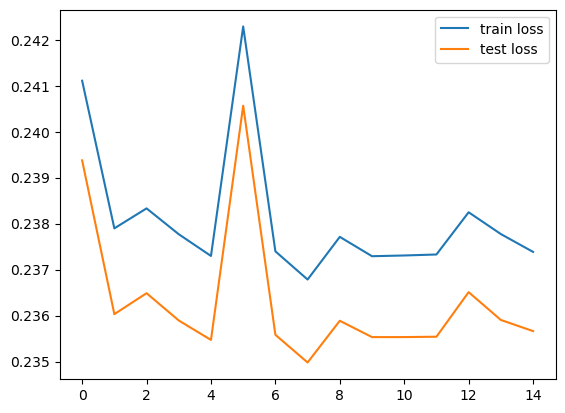

In [17]:
_ = plt.plot(train_losses, label='train loss')
_ = plt.plot(test_losses, label='test loss')
plt.legend();

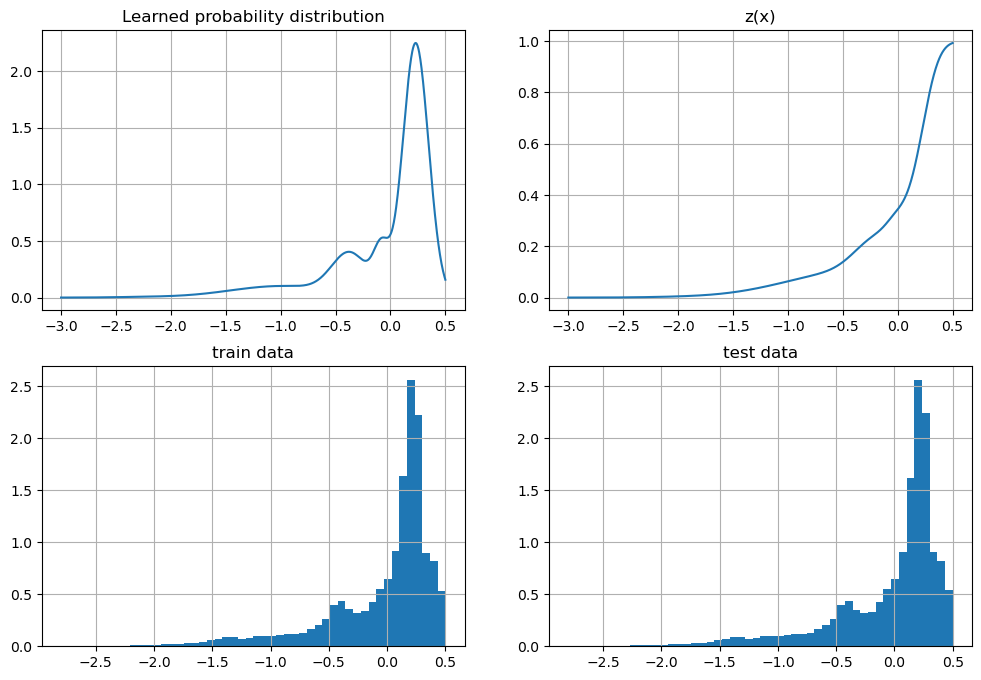

In [18]:
x = np.linspace(-3, 0.5, 1000)
with torch.no_grad():  #useful for inference, dosen't calculate the gradient
    z, dz_by_dx = flow(torch.FloatTensor(x)) #now flow is in inference mode
    px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().cpu().numpy()
    
_, axes = plt.subplots(2,2, figsize=(12, 8))
_ = axes[0, 0].grid(), axes[0, 1].grid(), axes[1, 0].grid(), axes[1, 1].grid()
_ = axes[0, 0].plot(x, px)
_ = axes[0, 0].set_title('Learned probability distribution')

_ = axes[0, 1].plot(x, z) #our target distribution as a combiantion of CDF 
_ = axes[0, 1].set_title('z(x)')

_ = axes[1, 0].hist(train_loader.dataset.array, bins=50, density=True)
_ = axes[1, 0].set_title("train data")
_ = axes[1, 1].hist(test_loader.dataset.array, bins=50, density=True)
_ = axes[1, 1].set_title("test data")

# would be important to try and get a Jansen-Shanno divergence instead of the KL